In [1]:
import numpy as np
import numpy.linalg as nl
import scipy
import scipy.linalg as sl
import matplotlib.pyplot as plt
import sys
sys.path.append('./src')

np.set_printoptions(suppress=True)

import warnings
warnings.filterwarnings('ignore')

## Set problem parameters

Solve homogeneous IVP
$$
\frac{\mathrm{d} u(t)}{\mathrm{d} t} = -A u(t),\quad u(0) = \vec{u}_0
$$

In [2]:
nq = 2 #2
dim = 2**nq
rng = np.random.Generator(np.random.PCG64(178983489))
T = 0.1 ## Define the time interval [0,T]

## Define random A and u0
u0 = np.matrix( rng.random((dim,1)) ,dtype=float) ## dtype complex is necessary for scipy to compute complex integral
u0 = u0/np.linalg.norm(u0, ord=2)
A = np.matrix(rng.random((dim,dim)),dtype=float)-0.5
A = 0.3*A + 1*np.identity(dim)

A,u0

(matrix([[ 1.08343391,  0.00741132, -0.12652406, -0.02231097],
         [ 0.03508775,  1.05847347,  0.04795957, -0.05734911],
         [ 0.00296627, -0.03657173,  0.97827624, -0.07091938],
         [-0.10321029, -0.08665902, -0.1158716 ,  0.86571847]]),
 matrix([[0.65217596],
         [0.68658323],
         [0.27092453],
         [0.17282905]]))

In [3]:
## beta and epsilon for LCHS parameters, epislon is the error tolerance
beta = 0.8 # 0< beta < 1
epsilon = 0.1 #0.05

## SciPy solution

In [4]:
### Scipy Homogenous solution
def ode_func_ho(t,u):
        return np.array(-A.dot(u).reshape(-1))[0]

spi_sol_ho = scipy.integrate.solve_ivp(ode_func_ho, [0,T],np.array(u0.reshape(-1))[0], method='RK45')
spi_uT_ho = spi_sol_ho.y[:,-1]
if np.linalg.norm(spi_uT_ho.imag,ord=2) < 1e-12:
    spi_uT_ho = spi_uT_ho.real
spi_uT_ho_norm = spi_uT_ho/np.linalg.norm(spi_uT_ho,ord=2)
spi_uT_ho_norm

array([0.65098474, 0.68096566, 0.27548933, 0.19133811])

## LCHS in classical computation

In [ ]:
from lchs import class_lchs_tihs

exp_op, uT = class_lchs_tihs(A, u0, T, beta, epsilon, 
                             trunc_multiplier=2, trotterLH=True, verbose=1)
uT = np.array(uT).reshape(-1).real
uT_norm = uT/np.linalg.norm(uT,ord=2)

print()
print("  Normalized Homogeneous u(T)= ", uT_norm)
print("  Normalized SciPy Sol   u(T)= ", spi_uT_ho_norm)
print("  Normalized Homogeneous solution error u(T): ", np.linalg.norm(uT_norm - spi_uT_ho_norm,ord=2))

  Preset parameters T =  0.1 beta =  0.8 epsilon =  0.1
  Truncation range [-K,K] K = 6.5132693702597155
  Step size h1 = 3.2566346851298578
  Number of nodes in [mh_1, (m+1)h_1] Q = 4
  Total number of nodes M = 16
  Truncation error bound = 11.69161205028889
  Quadrature error bound = 0.06158834728950542
  Total error bound = 11.753200397578397
  ||c||_1 = 1.3755854241393748
  ||u0||_2 = 0.9999999999999999

  Normalized Homogeneous u(T)=            [0.64558763 0.68410417 0.28175977 0.18928688]
  Normalized SciPy Sol   u(T)=            [0.65098474 0.68096566 0.27548933 0.19133811]
  Normalized Homogeneous solution error u(T)           : 0.00908322591231725


## DV LCHS

In [11]:
from lchs import quant_lchs_tihs

uT, lchs_circ_dv, full_state_dv, coeffs_dv, unitaries_dv, coeffs_unrot_dv, unitaries_unrot_dv = quant_lchs_tihs(A, u0, T, beta, epsilon, 
                                                        trunc_multiplier=2, trotterLH=True, verbose=1, rich_return=True, qiskit_api=True)
uT = np.array(uT).reshape(-1).real
uT_norm = uT/np.linalg.norm(uT,ord=2)

print()
print("  Normalized Quantum LCHS u(T)= ", uT_norm)
print("  Normalized SciPy Sol    u(T)= ", spi_uT_ho_norm)
print("  Normalized Quantum LCHS solution error u(T): ", np.linalg.norm(uT_norm - spi_uT_ho_norm,ord=2) )

  Preset parameters T =  0.1 beta =  0.8 epsilon =  0.1
  Truncation range [-K,K] K = 6.5132693702597155
  Step size h1 = 3.2566346851298578
  Number of nodes in [mh_1, (m+1)h_1] Q = 4
  Total number of nodes M = 16
  Truncation error bound = 11.69161205028889
  Quadrature error bound = 0.06158834728950542
  Total error bound = 11.753200397578397
  ||c||_1 = 1.3755854241393748
  LCU-Oracle: num_qubits_control= 4 num_qubits_op= 2
  Number of Qubits: 6

  Normalized Quantum LCHS u(T)=  [0.64350544 0.68518491 0.28409745 0.18897361]
  Normalized SciPy Sol    u(T)=  [0.65098474 0.68096566 0.27548933 0.19133811]
  Normalized Quantum LCHS solution error u(T):  0.01238679199592907


OrderedDict({'unitary': 2, 'initialize': 1, 'PREP': 1, 'SELECT': 1, 'state_preparation_dg': 1})


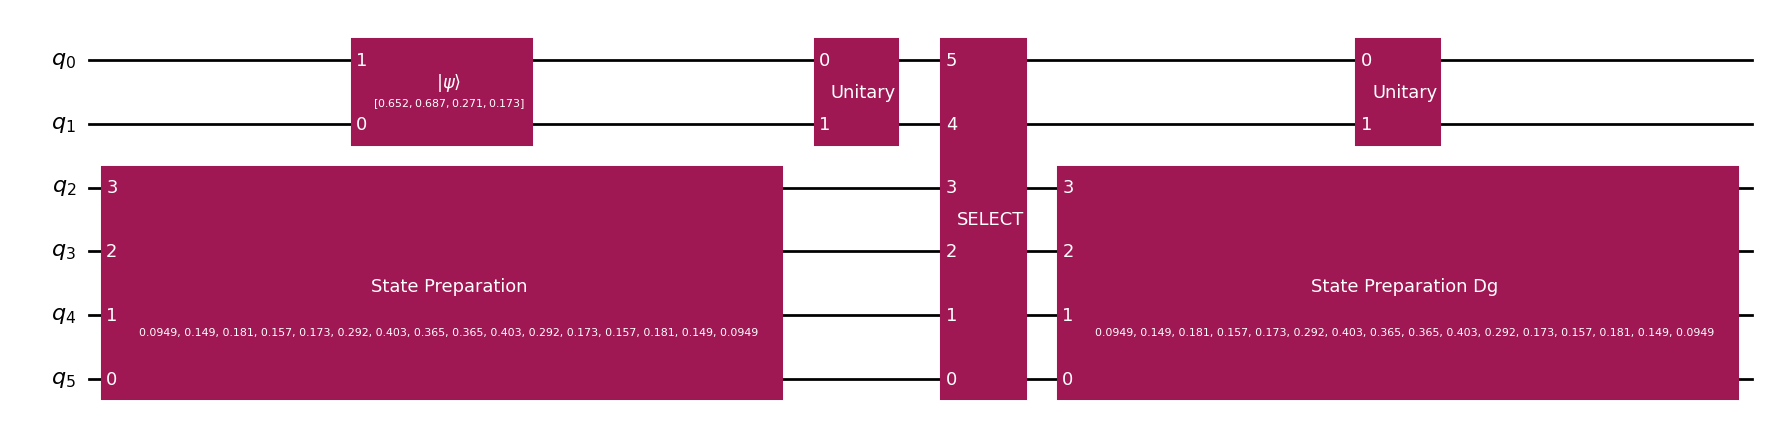

In [7]:
print(lchs_circ_dv.count_ops())
lchs_circ_dv.draw(output='mpl', fold=30, scale = 0.99)

## CV-DV LCHS with varational qubit-qumode ansatzes for Hamiltonian evolution

In [8]:
from vbos_lchs import bos_var_lchs_tihs

uT, lchs_circ_cd, circ_op_cd, coeffs_cd, unitaries_cd, coeffs_unrot_cd, unitaries_unrot_cd = bos_var_lchs_tihs(A, u0, T, beta, epsilon, 
                                                                                            trunc_multiplier=2, trotterLH=True, verbose=1)
uT = np.array(uT).reshape(-1).real
uT_norm = uT/np.linalg.norm(uT,ord=2)

print()
print("  Normalized Variational Bosonic LCHS u(T)= ", uT_norm)
print("  Normalized SciPy Sol                u(T)= ", spi_uT_ho_norm)
print("  Normalized Variational Bosonic LCHS solution error u(T): ", np.linalg.norm(uT_norm - spi_uT_ho_norm,ord=2) )

  Preset parameters T =  0.1 beta =  0.8 epsilon =  0.1
  Truncation range [-K,K] K = 6.5132693702597155
  Step size h1 = 3.2566346851298578
  Number of nodes in [mh_1, (m+1)h_1] Q = 4
  Total number of nodes M = 16
  Truncation error bound = 11.69161205028889
  Quadrature error bound = 0.06158834728950542
  Total error bound = 11.753200397578397
  ||c||_1 = 1.3755854241393748
  LCU-Oracle: num_qubits_control= 4 num_qubits_op= 2
  Number of Qubits: 7ess 16/16
>> State preparation for initial condition is DISABLED <<

  Normalized Variational Bosonic LCHS u(T)=            [0.66249836 0.67884048 0.2233314  0.22448747]
  Normalized SciPy Sol                u(T)=            [0.65098474 0.68096566 0.27548933 0.19133811]
  Normalized Variational Bosonic LCHS solution error u(T)           : 0.06289999145543988


OrderedDict({'x': 74, 'rz': 20, 'rx': 10, 'ECD': 10, 'PREP': 1, 'c_circuit-12903': 1, 'c_circuit-25445': 1, 'c_circuit-55455': 1, 'c_circuit-58581': 1, 'c_circuit-66371': 1, 'c_circuit-73941': 1, 'c_circuit-77463': 1, 'c_circuit-81865': 1, 'c_circuit-88863': 1, 'c_circuit-99381': 1, 'c_circuit-105015': 1, 'c_circuit-111969': 1, 'c_circuit-132695': 1, 'c_circuit-151177': 1, 'c_circuit-162443': 1, 'c_circuit-169837': 1, 'state_preparation_dg': 1})


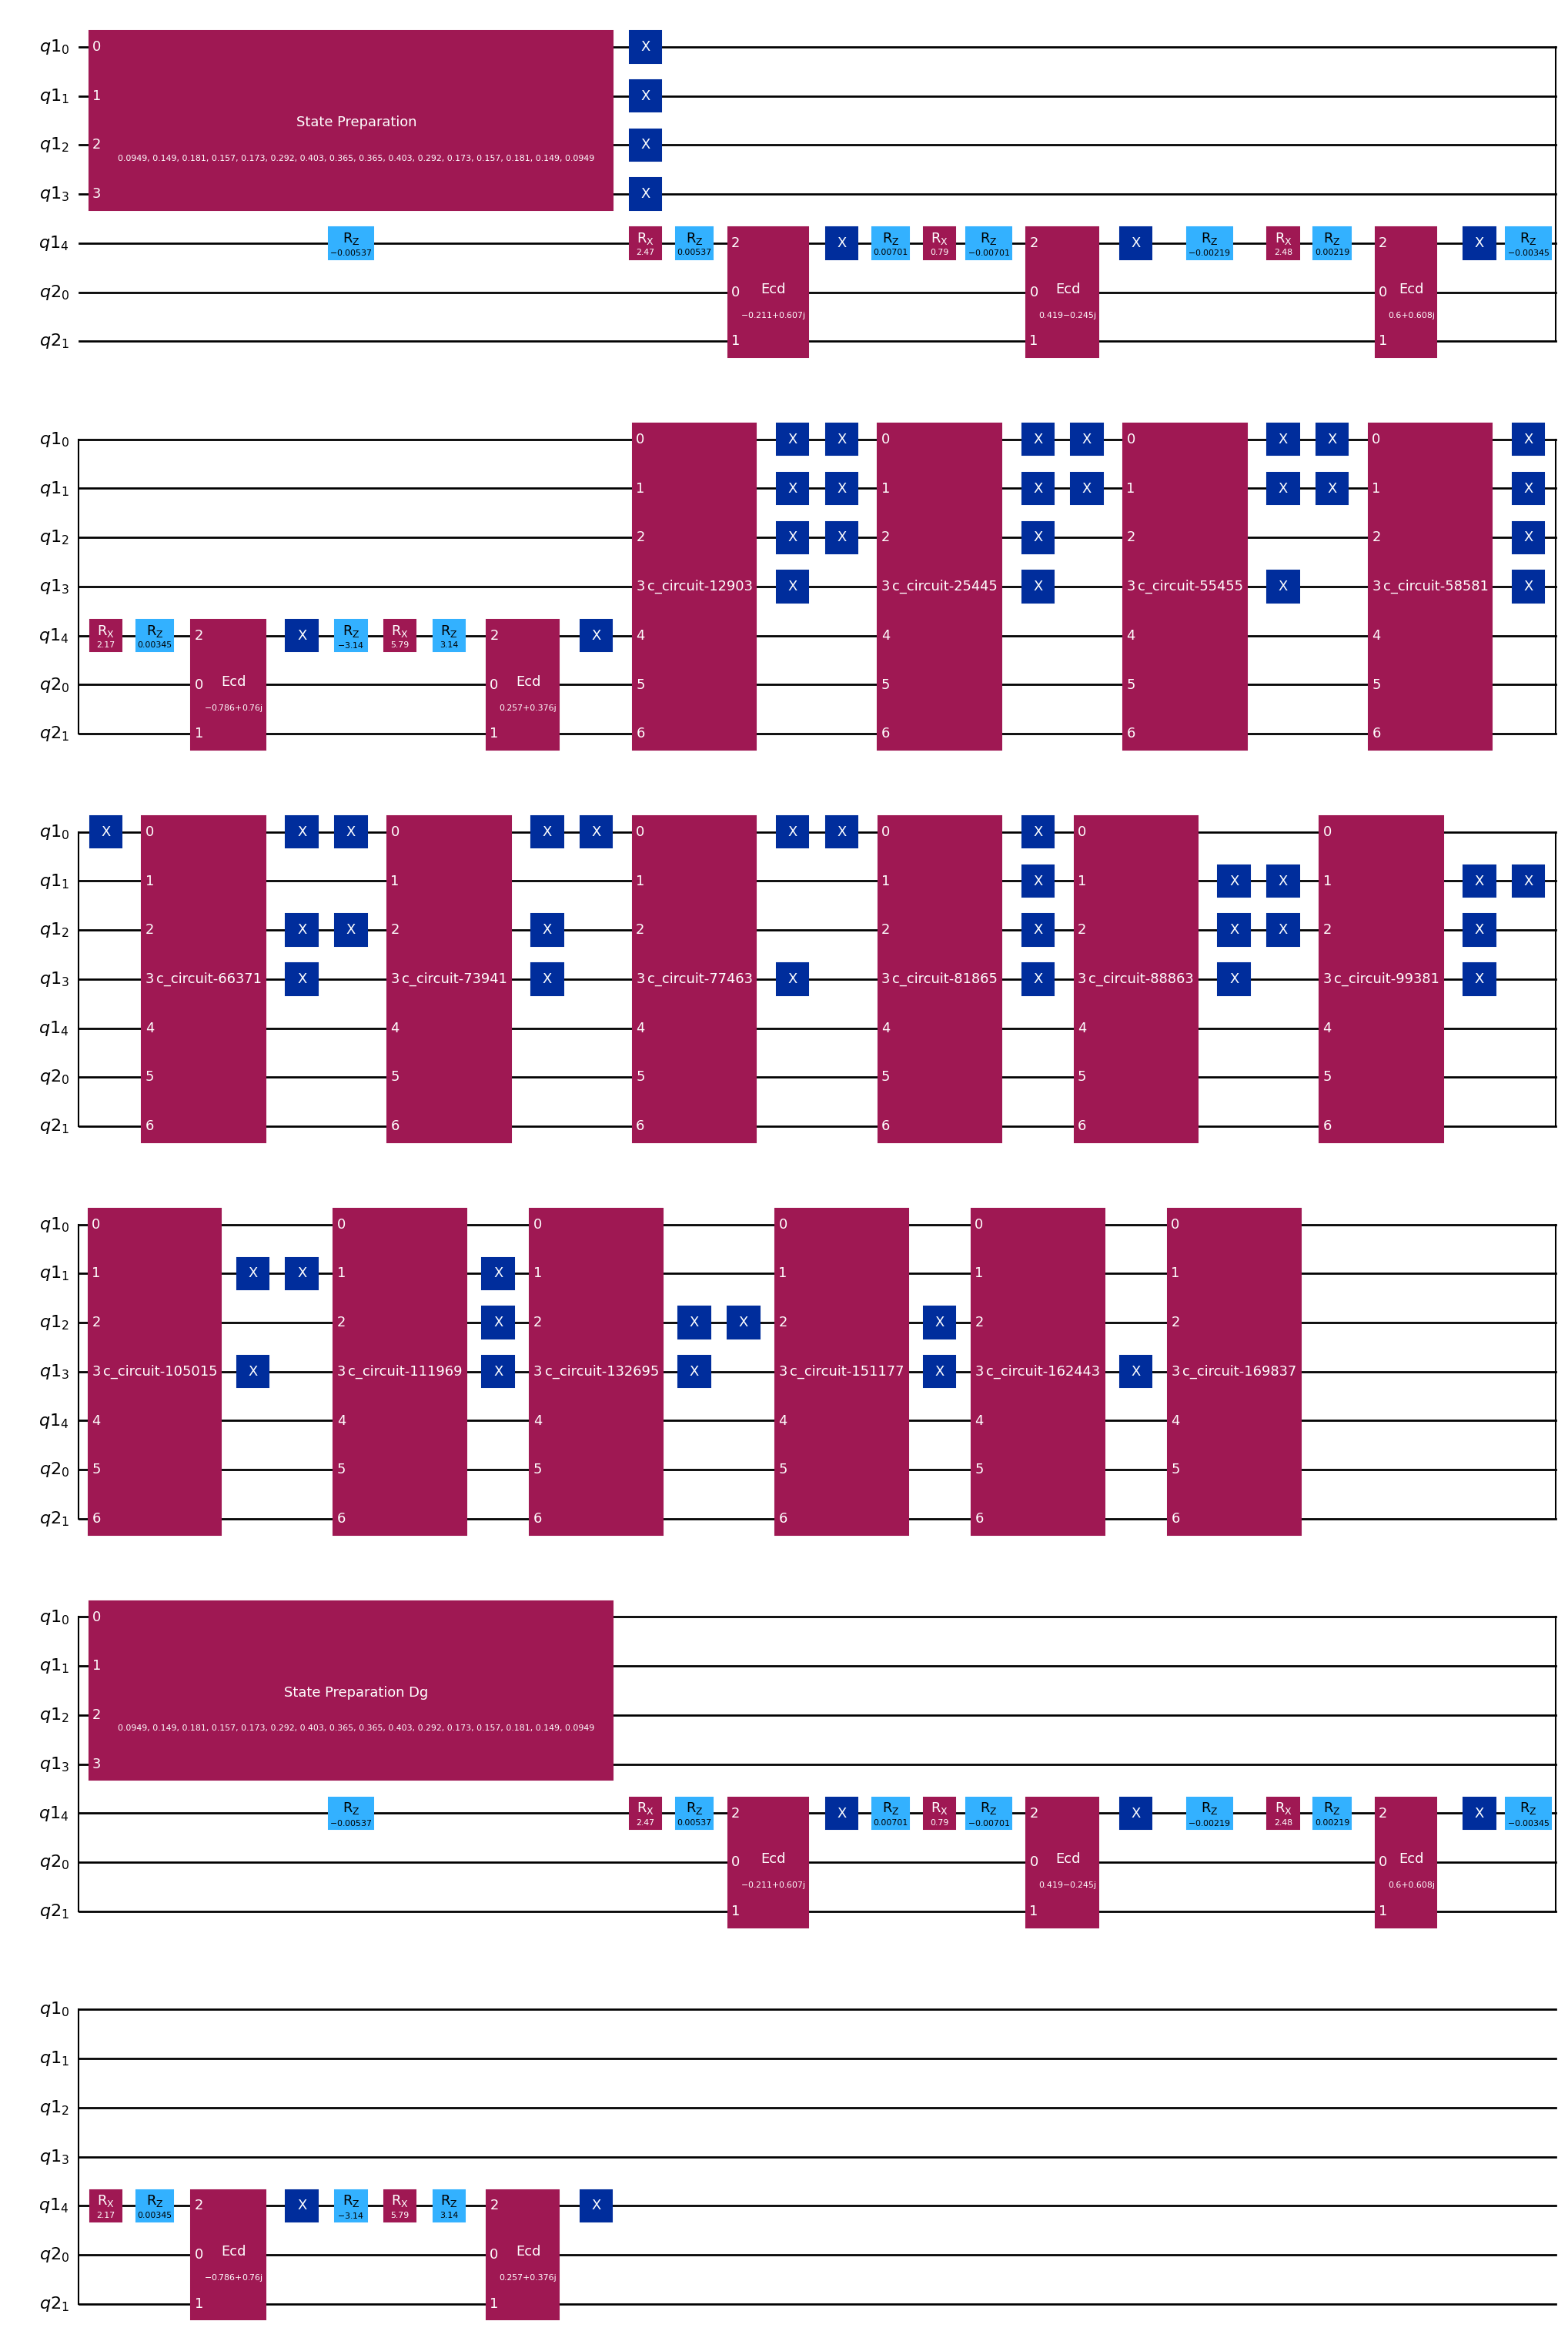

In [9]:
print(lchs_circ_cd.count_ops())
lchs_circ_cd.draw(output='mpl', fold=30, scale = 0.99)